# Chapter 5
# Resampling Methods 

It involves repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model. 

The process of evaluating a model's performance is known __model assessment.__

The process of selecting the proper level of flexibility for a model is known as __model selection.__

## Cross Validation :-

In absence of large designated test dataset, we can use the cross validation approach to estimate the test error rate by holding out a subset from training data.

### 1. Validation set approach :- 
It invloves randomly dividing the available set of observations into two parts, a training set, and a validation or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. 

The resulting validation set error rate, typically assessed using MSE in case of a quantitative response provides an estimate of the test error rate.

In [59]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

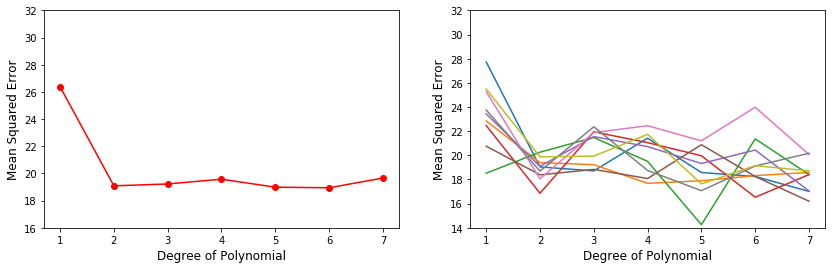

In [4]:
# Loading Auto dataset
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Auto.csv"
Auto = pd.read_csv(url, error_bad_lines = False, na_values = '?')

y = np.array(Auto.mpg)
X = np.array(Auto.horsepower).reshape(-1,1)

# Dividing the dataset in training and validation and getting validation MSE for different polynomial.
MSE = []
for i in range(7):
    polynomial_features= PolynomialFeatures(degree=i+1)
    xp = polynomial_features.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=20)
    model = sm.OLS(y_train,X_train).fit()
    MSE.append(mean_squared_error(y_test, model.predict(X_test)))
    
fig = plt.figure(figsize = (14,4))
ax1 = fig.add_subplot(121)
ax1.plot(list(range(1,8)), MSE, '-ok', color = "r")
ax1.set_ylim(16,32)
ax1.set_xlabel('Degree of Polynomial', fontsize = '12')
ax1.set_ylabel('Mean Squared Error', fontsize = '12')

# Dividing the dataset by setting different random state.

ax2 = fig.add_subplot(122)

for k in range(9):
    MSE = []
    for i in range(7):
        polynomial_features= PolynomialFeatures(degree=i+1)
        xp = polynomial_features.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=random.randint(1,100))
        model = sm.OLS(y_train,X_train).fit()
        MSE.append(mean_squared_error(y_test, model.predict(X_test)))
        
    ax2.plot(list(range(1,8)), MSE)
    
ax2.set_ylim(14,32)
ax2.set_xlabel('Degree of Polynomial', fontsize = '12')
ax2.set_ylabel('Mean Squared Error', fontsize = '12')

plt.show()

We can see the drawback of this approach in above plot. The validation error can be vary a lot depends on how we split the data. However all the plot shows that, MSE drops suddenly after adding polynomial of degree 2 and there is no use of adding polynomial terms of degree 3 or above. So it does help us in selecting the right model.

__Drawback:-__
1. The validation estimate of the test error can be highly variance , depending on precisely which observations are included in the training set and which are included in the validation set.
2. Since only a subset of observations are used to fit the model. Since statistical method tnd to perform worse when trained on fewer observations. This suggest that validation error rate tends to overestimate the test error rate for the model fit on the entire data set.

### Leave-One-Out-Cross-Validation (LOOCV) :-
In LOOCV, a single observation is used for the validation set, and the remaining observation make up the training set.

Since one observation ($i^{th}$) is not used in the fitting process, ${MSE}_i = (y_i - \hat y_i)$ provides an approximately unbiased estimate for the test error, but it is highly variable since it is based on single observation.

This process is repeated n times and produce n squared error ${MSE}_1$, ${MSE}_2$, .... , ${MSE}_n$. The LOOCV estimate for the test MSE is the average of these n test error estimates.
$${CV}_{(n)} = \frac{1}{n} \sum_{i = 1}^{n} {MSE}_i$$

__Advantage over validation approach__ :- 
1. LOOCV has a far less bias. It does not overestimate the test error rate as much as validation set approach.
2. LOOCV performance is not random, it gives same result as we are using almost every observation. 

The following formula holds for least square methods or polynomial regression:-
$${CV}_{(n)} = \frac{1}{n} \sum_{i = 1}^{n} (\frac{y_i - \hat y_i}{1 - h_i})^2$$
where $\hat y_i$ is the $i^{th}$ fitted value from the original least square fit, and $h_i$ is leverage. $h_i$ reflects the amount that an observation influence its own fit.
$$1/n < h_i < 1.$$
Hence, the residuals for high leverage points are inflated by exactly the right amount for this equality to hold.

The drawback of LOOCV is that for a large value of n, it might take a lot of time to run.

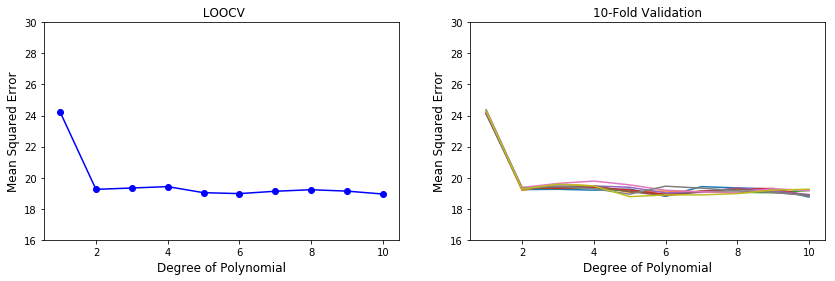

In [46]:
# LOOCV
y = np.array(Auto.mpg)
X = np.array(Auto.horsepower).reshape(-1,1)
model = LinearRegression()
loocv = LeaveOneOut()
mse = make_scorer(mean_squared_error)

# Dividing the dataset in training and validation and getting validation MSE for different polynomial.
MSE = []
for i in range(10):
    polynomial_features= PolynomialFeatures(degree=i+1)
    xp = polynomial_features.fit_transform(X)
    results = cross_val_score(model, xp, y, cv=loocv, scoring = mse)
    MSE.append(results.mean())

fig = plt.figure(figsize = (14,4))
ax1 = fig.add_subplot(121)
ax1.plot(list(range(1,11)), MSE, '-ok', color = "b")
ax1.set_ylim(16,30)
ax1.set_xlabel('Degree of Polynomial', fontsize = '12')
ax1.set_ylabel('Mean Squared Error', fontsize = '12')
ax1.set_title(" LOOCV")

# 10 - Fold validation for each polynomial curve.
ax2 = fig.add_subplot(122)

for k in range(9):
    MSE = []
    for i in range(10):
        polynomial_features= PolynomialFeatures(degree=i+1)
        xp = polynomial_features.fit_transform(X)
        kfold = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))
        results = cross_val_score(model, xp, y, cv=kfold, scoring = mse)
        MSE.append(results.mean())
        
    ax2.plot(list(range(1,11)), MSE)
    
ax2.set_ylim(16,30)
ax2.set_xlabel('Degree of Polynomial', fontsize = '12')
ax2.set_ylabel('Mean Squared Error', fontsize = '12')
ax2.set_title("10-Fold Validation")
plt.show()

We can see that even for 10 fold, validation error have less variance hence an improvement over the validation approach.

### K-Fold Cross Validation :-
The approach involves randomly dividing the set of observations into k groups of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining K-1 folds. The mean squared error is then computed on the observation in the held out fold. This procedure is repeated K times.

The process results in k estimates of the test error. The K-fold CV estimates is computed by averaging these values.
$${CV}_{(k)} = \frac{1}{K} \sum_{i = 1}^{K} {MSE}_i$$

LOOCV is a special case of K-fold CV. Advantage of Kfold over LOOCV is that it is less computationally expensive. 

When we perform cross validation, our goal might be to determine how well a given statistical learning procedure can be expected to perform on independent data. In this case actual estimate of test MSE is of interest.

But at other times we are interrested only in the location of the minimum point in the estimated test MSE curve to find out the suitable level of flexibility.

### Bias - Variance trade off for K-fold Cross Validation :-
KFold CV often gives more accurate estimate of the test error rate than LOOCV. This because of the bias-variance  trade off :-

__Bias__:- The validation set approach can lead to overestimate the test error, since in this approach the training set used to fit the statistical learning method contains only half the observations of entire dataset.

As LOOCV using almost all the observation, it provides approximately unbiased estimate. And KFold CV will lead to intermediate level of bias since each training set contains $\frac{(k-1)}{k}n.$

__Variance__:- When we perform LOOCV, we are in effect averaging the output of n fitted models each of which is trained on an almost identical set of observation, therefore these outputs are highly(positively) correlated with each other.

In K-Fold CV with k<n, we are averaging the output of K fitted models that are somewhat less correlated with each other since the overlap between the training sets in each model is smaller. Since the mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated, the test error estimate resulting from LOOCV tends to have high variance than does the test error estimate resulting from K-Fold CV.

## Cross Validation on Classification Problem :-
For classification, LOOCV error rate is
$${CV}_{(n)} = \frac{1}{n} \sum_{i = 1}^{n} {Err}_i$$
where ${Err}_i = I(y_i \ne \hat y_i)$
Cross validation error can be used to decide on the flexibility of the learning method. We can plot CV error with increasing flexibility and select the one with minimum error rate.

## The Bootstrap

Bootstrap can be used to quantify the uncertainity associated with a given estimator or statistical learning method.

The idea is to find out the variability around an estimator. To do that we need a lot sample dataset and then calculating the same estimate and then calculating the variance. But it is not possible to generate new sample dataset from population as we mostly have just one sample available. 

The bootstrap obtain distinct datasets by repeatedly sampling observation from the original dataset. 

We continously sample observation (with replacement), n, and use them to calculate the value of estimator $\alpha$. We continue this process till B times. We can compute standard error of these bootstrap estimates using
$${SE}_B(\hat \alpha) = \sqrt {\frac{1}{B-1} \sum_{r = 1}^{B} (\hat \alpha^{*r} - \frac{1}{B} \sum_{r^{'} = 1}^{B} \hat \alpha^{*r^{i}})^2}$$
Bootstrap can be used to find SE of any estimate.

Also, in case of linear regression, if the true relationship is not linear, bootstrap provides better estimates of standard error as it is non-paramteric. The standard formulas use $\hat \sigma^2$ estimate whch rely on assumption that linear model is correct.

## _Lab: Cross- Validation and Bootstrap_

### Lab : The validation set approach

We will see how to implement validation approach in Python.

In [4]:
# Loading Auto dataset
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Auto.csv"
Auto = pd.read_csv(url, error_bad_lines = False, na_values = '?')

X = np.array(Auto['horsepower']).reshape(-1,1)
y = np.array(Auto['mpg'])

# Divinding the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)

# Linear Regression on training set.
lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

26.374851162407953


In [6]:
# Now we will fit the model with polynomial terms degree 2.
polynomial_features= PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=20)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

19.08836013278956


In [7]:
# Now we will fit the model with polynomial terms degree 3.

polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=20)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

19.225822236707103


We see that the error for degree 1,2 and 3 are 26.4, 19 and 19.1 respectively. Now we will select a different split of train and test data.

In [8]:
# Divinding the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)

# Linear Regression on training set.
lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

22.854297270308564


In [9]:
polynomial_features= PolynomialFeatures(degree=2)
xp = polynomial_features.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=40)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

17.211724297391374


In [10]:
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(xp, y, test_size=0.5, random_state=40)

lm = LinearRegression()
lm.fit(X_train,y_train)

print(mean_squared_error(y_test, lm.predict(X_test)))

17.643970964506913


We can see that using a different split results in different estimates of test error rate.

### Lab : Leave-One-Out Cross-Validation

In [13]:
# We can use cross_val_score to get the LOOCV.
lm = LinearRegression()
loocv = LeaveOneOut()
mse = make_scorer(mean_squared_error)

print(cross_val_score(lm, X,y, scoring = mse, cv = loocv).mean())

24.231513517929226


cross_val_score will return n estimates of test error. We will take mean of all to get our LOOCV estimate of test error which is 24.23.

In [16]:
# We can calculate LOOCV estiamte for few polynomial models as well.
cv_error = []
lm = LinearRegression()
loocv = LeaveOneOut()
mse = make_scorer(mean_squared_error)
for i in range(5):
    polynomial_features= PolynomialFeatures(degree=i+1)
    xp = polynomial_features.fit_transform(X)
    results = cross_val_score(lm, xp, y, cv=loocv, scoring = mse)
    cv_error.append(results.mean())
print(cv_error)

[24.231513517929226, 19.24821312448941, 19.33498406411397, 19.424430309374937, 19.03322024895203]


We can see that there is a sudden drop in MSE for degree 1 to 2 but no significant drop later on.

### Lab : K-Fold Cross Validation

In [18]:
# we will define K using KFold function and use it cross_val_score and compute the K Fold validation error.
kfold = KFold(n_splits = 10, shuffle =  True, random_state = random.randint(1,100))

cv_error = []
lm = LinearRegression()
kfold = KFold(n_splits = 10, shuffle =  True, random_state = 20)
mse = make_scorer(mean_squared_error)
for i in range(10):
    polynomial_features= PolynomialFeatures(degree=i+1)
    xp = polynomial_features.fit_transform(X)
    results = cross_val_score(lm, xp, y, cv=kfold, scoring = mse)
    cv_error.append(results.mean())
print(cv_error)

[24.248098354964892, 19.44593146195417, 19.572871855288646, 19.65952642053599, 19.12821822130557, 19.068743429073542, 19.208172513444264, 19.3147016080953, 19.26176031355881, 19.19136395196935]


### Lab : The Bootstrap

In [48]:
# First we will create a function that will calculate an estimate based on some data.
def alpha_fn(data, index):
    X = data.X[index]
    Y = data.Y[index]
    return((Y.var() - np.cov(X,Y)[0,1])/(Y.var() + X.var() - 2 * np.cov(X,Y)[0,1]))

url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Portfolio.csv"
Portfolio = pd.read_csv(url, error_bad_lines = False, na_values = '?')
alpha_fn(Portfolio, list(range(100)))

0.57583207459283

In [54]:
# Now we will select a sample with replacement using np.random.choice and calculate the estimate again.
alpha_fn(Portfolio, list(np.random.choice(100, 100)))

0.6658474919393282

In [ ]:
# boot function alternate is not in python. So we need to write our own function.
